The following Jupyter notebook is sourced here: https://medium.com/@rekalantar/variational-auto-encoder-vae-pytorch-tutorial-dce2d2fe0f5f

In [41]:
import os
os.environ["KMP_DUPLICATE_LIB_OK"] = "TRUE"
# Some environment variable 'libiomp5md.dll' is causing kernel crashes, this is just to fix it for now.

import torch
import numpy as np
import torch.nn as nn
from torch.optim import Adam
import matplotlib.pyplot as plt
from torchvision.datasets import MNIST
from torch.utils.data import DataLoader
import torchvision.transforms as transforms
from mpl_toolkits.axes_grid1 import ImageGrid
from torchvision.utils import save_image, make_grid
from sklearn.cluster import MeanShift, estimate_bandwidth

In [42]:
# create a transofrm to apply to each datapoint
transform = transforms.Compose([transforms.ToTensor()])

# download the MNIST datasets
path = "~/datasets"
train_dataset = MNIST(path, transform=transform, download=True)
test_dataset = MNIST(path, transform=transform, download=True)

# create train and test dataloaders
batch_size = 100
train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

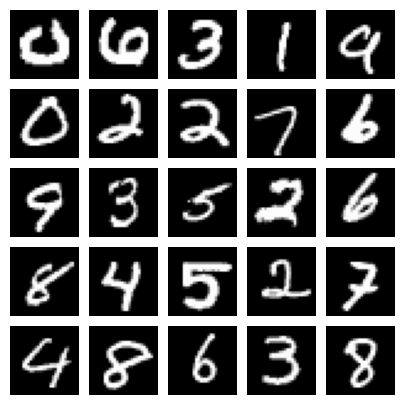

In [43]:
# get 25 sample training images for visualization
dataiter = iter(train_loader)
image = next(dataiter)

num_samples = 25
sample_images = [image[0][i, 0] for i in range(num_samples)]

fig = plt.figure(figsize=(5, 5))
grid = ImageGrid(fig, 111, nrows_ncols=(5, 5), axes_pad=0.1)

for ax, im in zip(grid, sample_images):
    ax.imshow(im, cmap="gray")
    ax.axis("off")

plt.show()

In [44]:
class Encoder(nn.Module):

    def __init__(self, input_dim=784, hidden_dim=512, latent_dim=256):
        super(Encoder, self).__init__()

        self.linear1 = nn.Linear(input_dim, hidden_dim)
        self.linear2 = nn.Linear(hidden_dim, hidden_dim)
        self.mean = nn.Linear(hidden_dim, latent_dim)
        self.var = nn.Linear(hidden_dim, latent_dim)
        self.LeakyReLU = nn.LeakyReLU(0.2)
        self.training = True

    def forward(self, x):
        x = self.LeakyReLU(self.linear1(x))
        x = self.LeakyReLU(self.linear2(x))

        mean = self.mean(x)
        log_var = self.var(x)
        return mean, log_var

In [45]:
class Decoder(nn.Module):

    def __init__(self, output_dim=784, hidden_dim=512, latent_dim=256):
        super(Decoder, self).__init__()

        self.linear2 = nn.Linear(latent_dim, hidden_dim)
        self.linear1 = nn.Linear(hidden_dim, hidden_dim)
        self.output = nn.Linear(hidden_dim, output_dim)
        self.LeakyReLU = nn.LeakyReLU(0.2)

    def forward(self, x):
        x = self.LeakyReLU(self.linear2(x))
        x = self.LeakyReLU(self.linear1(x))

        x_hat = torch.sigmoid(self.output(x))
        return x_hat

In [46]:
class VAE(nn.Module):

    def __init__(
        self, input_dim=784, hidden1_dim=400, hidden2_dim=200, latent_dim=2, device=device
    ):
        super(VAE, self).__init__()

        self.input_dim = input_dim
        self.hidden1_dim = hidden1_dim
        self.hidden2_dim = hidden2_dim
        self.latent_dim = latent_dim
        self.device = device

        # encoder
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, hidden1_dim),
            nn.LeakyReLU(0.2),
            nn.Linear(hidden1_dim, hidden2_dim),
            nn.LeakyReLU(0.2),
        ).to(device)

        # latent mean and Cholesky decomp of covariance
        self.mean_layer = nn.Linear(hidden2_dim, latent_dim, device=device)
        self.chol_layer = nn.Linear(
            hidden2_dim, (latent_dim * (latent_dim + 1)) // 2, device=device
        )

        # decoder
        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, hidden2_dim),
            nn.LeakyReLU(0.2),
            nn.Linear(hidden2_dim, hidden1_dim),
            nn.LeakyReLU(0.2),
            nn.Linear(hidden1_dim, input_dim),
            nn.Sigmoid(),
        ).to(device)

    def encode(self, x):
        x = self.encoder(x)
        mean, chol = self.mean_layer(x), self.chol_layer(x)
        return mean, chol

    def reparameterization(self, mean, chol):
        epsilon = torch.randn_like(mean, device=self.device)
        batch_size = mean.shape[0]
        L = torch.zeros(batch_size, self.latent_dim, self.latent_dim, device=self.device)
        tril_indices = torch.tril_indices(
            self.latent_dim, self.latent_dim, offset=0, device=self.device
        )
        L[:, tril_indices[0], tril_indices[1]] = chol
        z = mean + torch.einsum("bij,bj->bi", L, epsilon)
        return z

    def decode(self, x):
        return self.decoder(x)

    def forward(self, x):
        mean, chol = self.encode(x)
        z = self.reparameterization(mean, chol)
        x_hat = self.decode(z)
        return x_hat, mean, chol

In [47]:
class Flatten(nn.Module):
    def forward(self, input):
        return input.view(input.size(0), -1)

In [48]:
class UnFlatten(nn.Module):
    def forward(self, input, size=7*7*32):
        return input.view(input.size(0), size, 1, 1)

In [49]:
class CNN_VAE(nn.Module):

    def __init__(
        self, input_dim=784, latent_dim=3, device=device
    ):
        super(CNN_VAE, self).__init__()

        self.input_dim = input_dim
        self.latent_dim = latent_dim
        self.device = device

        # encoder
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 16, kernel_size=3, stride=1, padding=1), # 28 to 28
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2), # 28 to 14
            nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1), # 14 to 14
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2), # 14 to 7            
        ).to(device)

        # latent mean and Cholesky decomp of covariance
        self.fc1 = nn.Linear(7*7*32, 7*7*16)
        self.fc2 = nn.Linear(7*7*16, 7*7*8)
        self.fc3 = nn.Linear(7*7*8, 7*7*16)
        self.fc4 = nn.Linear(7*7*16, 7*7*32)
        self.mean_layer = nn.Linear(7*7*8, latent_dim, device=device)
        self.chol_layer = nn.Linear(7*7*8, (latent_dim * (latent_dim + 1)) // 2, device=device)
        self.decode_layer = nn.Linear(latent_dim, 7*7*8)

        # decoder
        self.decoder = nn.Sequential(
            nn.Upsample((14,14)), # Upsample + Conv, as opposed to TransposeConv
            nn.Conv2d(32, 16, kernel_size=3, stride=1, padding=1),  # 14 to 14
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.Upsample((28,28)),
            nn.Conv2d(16, 1, kernel_size=3, stride=1, padding=1), #28 to 28
            nn.Sigmoid(),
        ).to(device)
        
    def encode(self, x):
        x = self.encoder(x)
        # print(x.shape)
        x = x.view(x.size(0), -1) # Flattening...
        x = self.fc1(x)
        x = self.fc2(x)
        # print(x.shape)
        mean, chol = self.mean_layer(x), self.chol_layer(x)
        return mean, chol

    def reparameterization(self, mean, chol):
        epsilon = torch.randn_like(mean, device=self.device)
        batch_size = mean.shape[0]
        L = torch.zeros(batch_size, self.latent_dim, self.latent_dim, device=self.device)
        tril_indices = torch.tril_indices(
            self.latent_dim, self.latent_dim, offset=0, device=self.device
        )
        L[:, tril_indices[0], tril_indices[1]] = chol
        z = mean + torch.einsum("bij,bj->bi", L, epsilon)
        return z

    def decode(self, x):
        x = self.decode_layer(x)
        x = self.fc3(x)
        x = self.fc4(x)
        x = x.view(x.size(0), 32, 7, 7) #Unflattening...
        return self.decoder(x)

    def forward(self, x):
        mean, chol = self.encode(x)
        z = self.reparameterization(mean, chol)
        x_hat = self.decode(z)
        return x_hat, mean, chol

The following is a modification of the VAE using a convolutional network. 
https://www.datacamp.com/tutorial/pytorch-cnn-tutorial
https://github.com/sksq96/pytorch-vae/blob/master/vae.py

In [50]:
model = CNN_VAE().to(device)
optimizer = Adam(model.parameters(), lr=1e-3, weight_decay=1e-8)

In [51]:
def loss_function(x, x_hat, mean, chol):
    reproduction_loss = nn.functional.binary_cross_entropy(x_hat, x, reduction="sum")

    batch_size = mean.shape[0]
    L = torch.zeros(batch_size, model.latent_dim, model.latent_dim, device=model.device)
    tril_indices = torch.tril_indices(
        model.latent_dim, model.latent_dim, offset=0, device=model.device
    )
    L[:, tril_indices[0], tril_indices[1]] = chol

    Sigma = torch.einsum("bij,bkj->bik", L, L)

    KLD = 0.5 * (
        torch.mean(torch.sum(mean.pow(2), axis=-1))
        + torch.mean(torch.sum(torch.diagonal(Sigma, offset=0, dim1=-2, dim2=-1), axis=-1))
        - torch.mean(torch.linalg.slogdet(Sigma).logabsdet)
        - model.latent_dim
    )

    return reproduction_loss + KLD

In [52]:
def train(model, optimizer, epochs, device, x_dim=784):
    model.train()
    for epoch in range(epochs):
        overall_loss = 0
        for batch_idx, (x, _) in enumerate(train_loader):
            x = x.to(device) # x.view(batch_size, x_dim).to(device)

            optimizer.zero_grad()

            x_hat, mean, log_var = model(x)
            loss = loss_function(x, x_hat, mean, log_var)

            overall_loss += loss.item()

            loss.backward()
            optimizer.step()

        print("\tEpoch", epoch + 1, "\tAverage Loss: ", overall_loss / (batch_idx * batch_size))
    return overall_loss

In [85]:
train(model, optimizer, epochs=50, device=device)

	Epoch 1 	Average Loss:  169.03207195912458
	Epoch 2 	Average Loss:  160.8907876734662
	Epoch 3 	Average Loss:  154.18663782084724
	Epoch 4 	Average Loss:  146.58310047996662
	Epoch 5 	Average Loss:  146.1203477638512
	Epoch 6 	Average Loss:  142.5191025243896
	Epoch 7 	Average Loss:  146.19891583628964
	Epoch 8 	Average Loss:  142.57281743987375
	Epoch 9 	Average Loss:  144.749014128365
	Epoch 10 	Average Loss:  141.17569852749375
	Epoch 11 	Average Loss:  140.1946884618896
	Epoch 12 	Average Loss:  140.06797390181552
	Epoch 13 	Average Loss:  139.22693497952315
	Epoch 14 	Average Loss:  138.84949246465465
	Epoch 15 	Average Loss:  139.31250586915692
	Epoch 16 	Average Loss:  139.09882236996557
	Epoch 17 	Average Loss:  140.80985462424354
	Epoch 18 	Average Loss:  139.13232899559162
	Epoch 19 	Average Loss:  138.01497515390233
	Epoch 20 	Average Loss:  137.60097511151397
	Epoch 21 	Average Loss:  138.76263437108722
	Epoch 22 	Average Loss:  139.3229327851106
	Epoch 23 	Average Loss:  

8285435.900390625

In [86]:
def generate_digit(latent_vec):
    z_sample = torch.tensor([latent_vec], dtype=torch.float, device=model.device)
    x_decoded = model.decode(z_sample)
    digit = x_decoded.detach().cpu().reshape(28, 28)  # reshape vector to 2d array
    plt.title(f"[{latent_vec[0]},{latent_vec[1]}]")
    plt.imshow(digit, cmap="gray")
    plt.axis("off")
    plt.show()

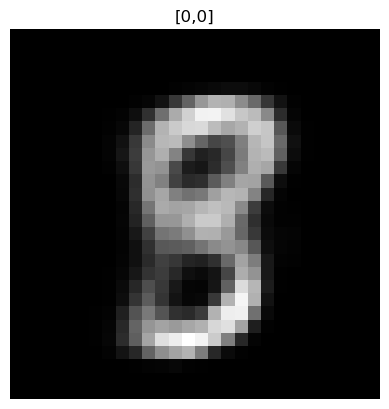

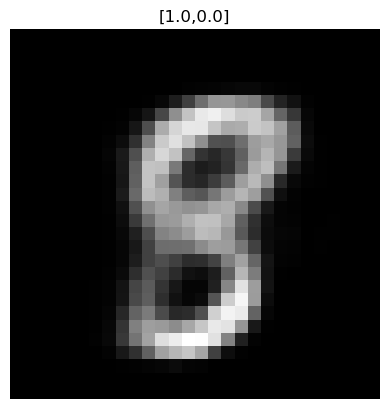

(None, None)

In [87]:
generate_digit([0,0,0]), generate_digit([1.0, 0.0,0]) 

## Visualize the embedding of the training examples

In [88]:
from collections import defaultdict

encoded_reps = defaultdict(list)

for batch_idx, (x, labels) in enumerate(train_loader):
    # x = x.view(batch_size, 784).to(device)
    mean_reps, chol_rep = model.encode(x)
    for rep, label in zip(mean_reps, labels):
        encoded_reps[int(label)].append(rep.detach().cpu().numpy())

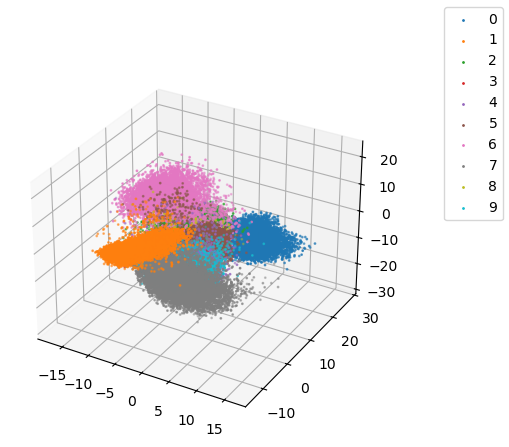

In [89]:
fig = plt.figure()
ax = fig.add_subplot(projection="3d")
for label in range(10):
    ax.scatter(*zip(*encoded_reps[label]), s=1, label=str(label))

fig.legend()

## Visualize the generative model

In [36]:
def plot_latent_space(model, scale=5.0, n=25, digit_size=28, figsize=15):
    # display a n*n 2D manifold of digits
    figure = np.zeros((digit_size * n, digit_size * n))

    # construct a grid
    grid_x = np.linspace(-scale, scale, n)
    grid_y = np.linspace(-scale, scale, n)[::-1]

    for i, yi in enumerate(grid_y):
        for j, xi in enumerate(grid_x):
            z_sample = torch.tensor([[xi, yi,0]], dtype=torch.float, device=model.device)
            x_decoded = model.decode(z_sample)
            digit = x_decoded[0].detach().cpu().reshape(digit_size, digit_size)
            figure[
                i * digit_size : (i + 1) * digit_size,
                j * digit_size : (j + 1) * digit_size,
            ] = digit

    plt.figure(figsize=(figsize, figsize))
    plt.title("VAE Latent Space Visualization")
    start_range = digit_size // 2
    end_range = n * digit_size + start_range
    pixel_range = np.arange(start_range, end_range, digit_size)
    sample_range_x = np.round(grid_x, 1)
    sample_range_y = np.round(grid_y, 1)
    plt.xticks(pixel_range, sample_range_x)
    plt.yticks(pixel_range, sample_range_y)
    plt.xlabel("z [0]")
    plt.ylabel("z [1]")
    plt.imshow(figure, cmap="Greys_r")
    plt.show()

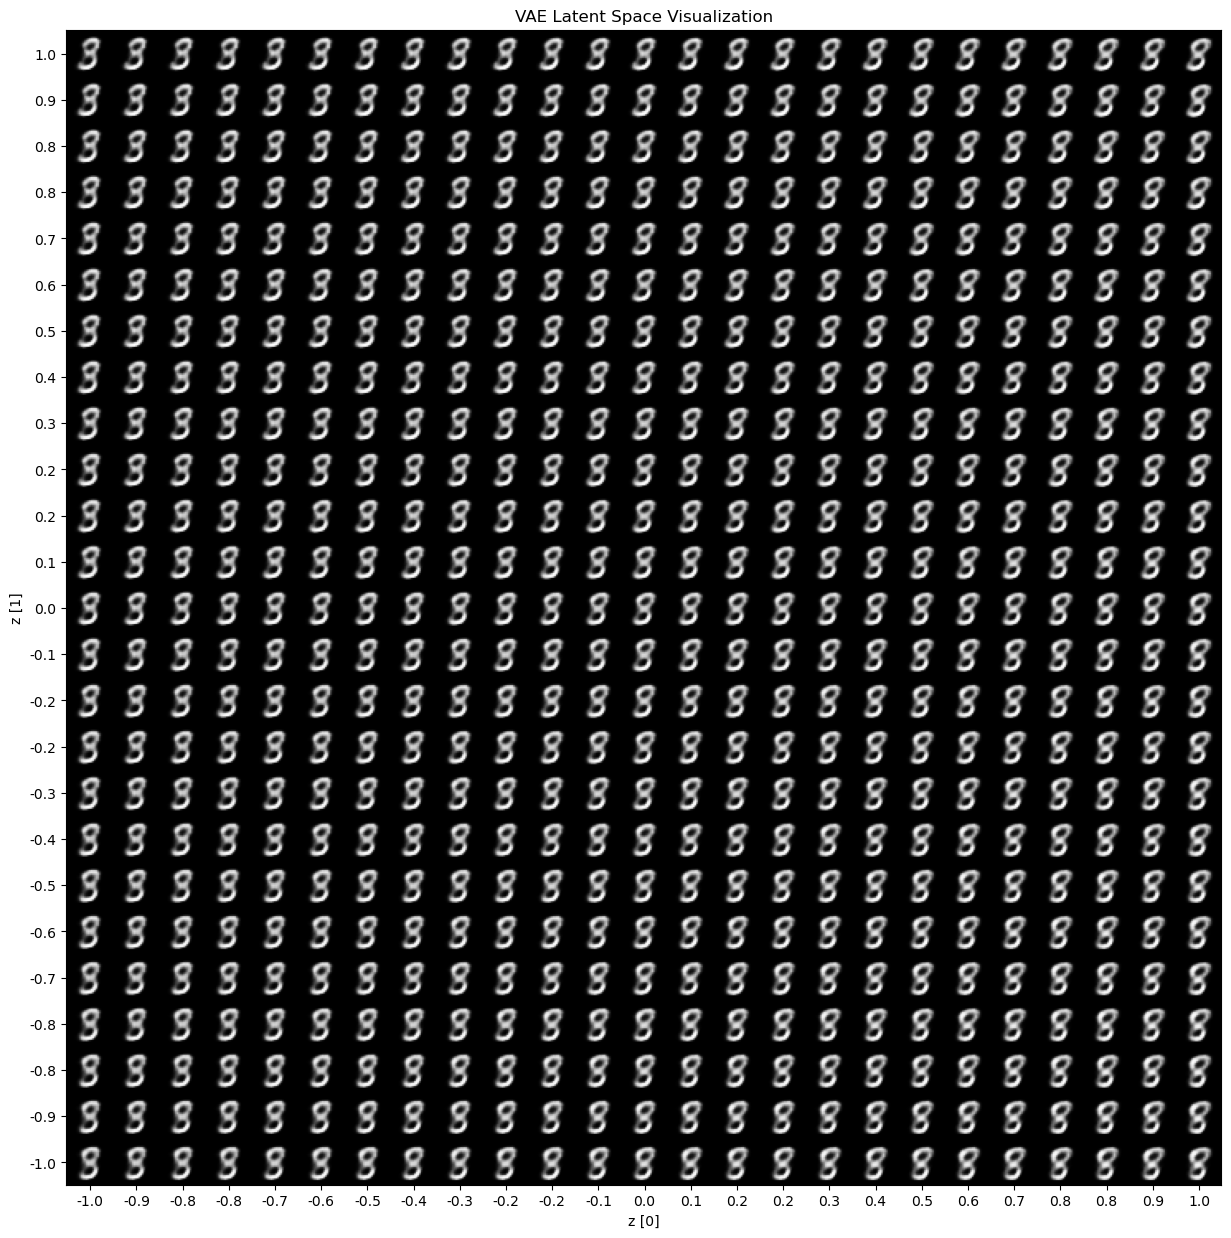

In [37]:
plot_latent_space(model, scale=1.0)

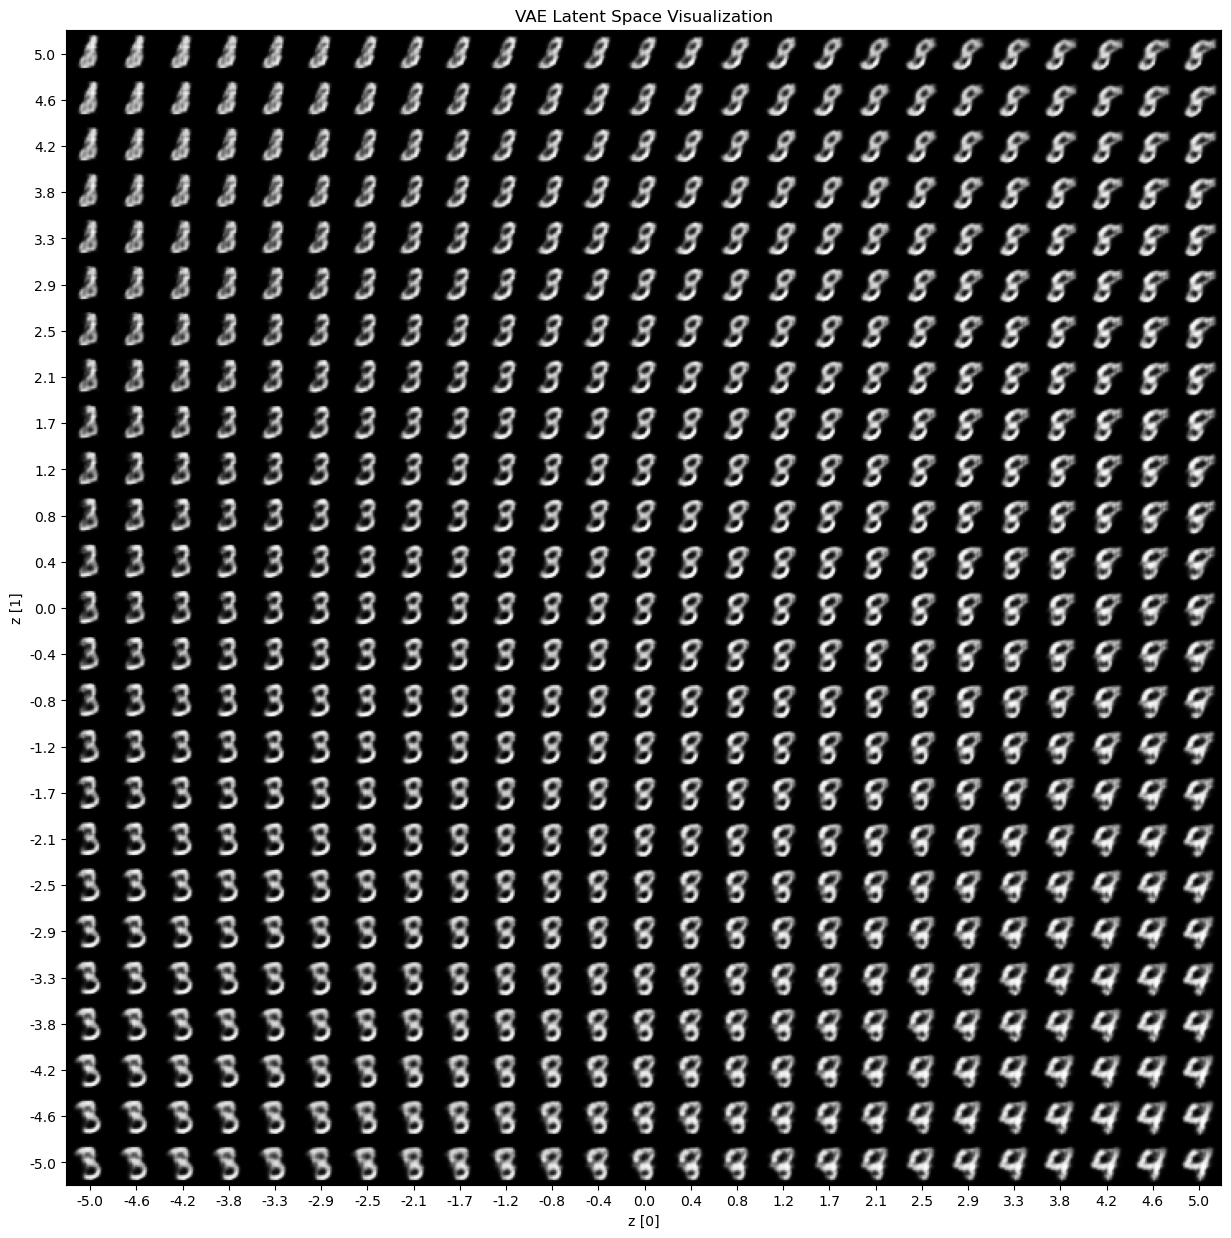

In [38]:
plot_latent_space(model, scale=5.0)

## Generating Chosen Numbers

In [65]:
for x, vect in encoded_reps.items():
    print(vect)

[array([-0.49678794,  6.731003  , -3.7640605 ], dtype=float32), array([ 3.7362127 , -0.12872712, -1.9068723 ], dtype=float32), array([ 2.3356442,  1.2414651, -1.4225156], dtype=float32), array([ 0.5647007,  2.8163552, -6.00196  ], dtype=float32), array([3.1127954, 1.6440892, 0.5459381], dtype=float32), array([ 2.9780228,  1.1532551, -5.7738094], dtype=float32), array([ 1.2635927,  3.6807861, -3.0460014], dtype=float32), array([2.3344305, 1.9781725, 1.0385942], dtype=float32), array([ 3.4684176 ,  0.64561224, -2.8135562 ], dtype=float32), array([ 0.18563285,  3.300271  , -5.1922526 ], dtype=float32), array([ 1.4001004,  4.1988497, -3.1382437], dtype=float32), array([ 3.120397 ,  1.2197773, -0.5120116], dtype=float32), array([-0.38700396,  4.405736  ,  2.0204191 ], dtype=float32), array([-0.89440465,  4.0889025 , -7.278774  ], dtype=float32), array([3.8606691, 0.3806439, 0.4100803], dtype=float32), array([ 1.5006442,  1.5106726, -4.5628004], dtype=float32), array([ 4.5890718,  0.7187185,

The following is pulled from the Sklearn demo here: https://scikit-learn.org/stable/auto_examples/cluster/plot_mean_shift.html#sphx-glr-auto-examples-cluster-plot-mean-shift-py

In [ ]:
X = []
for label, vect in encoded_reps.items():
    for v in vect:
        X.append(v)
bandwidth = estimate_bandwidth(X, n_samples=5000)

ms = MeanShift(bandwidth=bandwidth, bin_seeding=True)
ms.fit(X)
labels = ms.labels_
cluster_centers = ms.cluster_centers_

labels_unique = np.unique(labels)
n_clusters_ = len(labels_unique)

KeyboardInterrupt: 

[ True  True  True ...  True  True  True]


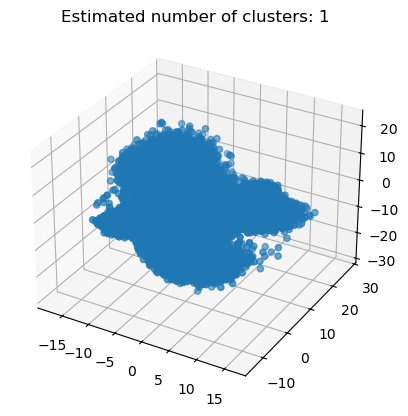

In [100]:
plt.figure(1)
plt.clf()

colors = ["#dede00", "#377eb8", "#f781bf"]
markers = ["x", "o", "^"]

ax = plt.axes(projection="3d")

X = np.asarray(X)

for k, col in zip(range(n_clusters_), colors):
    my_members = labels == k
    print(my_members)
    cluster_center = cluster_centers[int(k)]
    ax.scatter(X[my_members, 0], X[my_members, 1], X[my_members, 2])
    ax.scatter(cluster_center[0], cluster_center[1], cluster_center[2])
plt.title("Estimated number of clusters: %d" % n_clusters_)
plt.show()